In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import functions as fnc
import time
import sys
import json
from tqdm import tqdm


In [2]:
OutDIR='/DATA/vito/output/Ravi2_run2_dw4_10_3b_minarea/'

print('Loaded parameters from '+OutDIR)
with open(OutDIR+'init_para.json', 'r') as json_file:
    init_para = json.load(json_file)
with open(OutDIR+'pre_para.json', 'r') as json_file:
    pre_para = json.load(json_file)

print(init_para)
print(pre_para)


OutDIR=init_para.get('OutDIR')
DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=init_para.get('fid')

#defining clips
b=init_para.get('b')
crop_size=init_para.get('crop_size')
resample_factor=init_para.get('resample_factor')

image=fnc.load_image(DataDIR,DSname,fid)
org_shape=image.shape
print('Image size:', image.shape)

if resample_factor!=1:
    image=fnc.preprocessing_roulette(image, pre_para)
    print('Resampled to: ', image.shape)

print('Loading clips.....')

clips_pths = glob.glob(OutDIR+f'chunks/chunk_*')
clips_pths.sort()


print(len(clips_pths),' clips imported')


Loaded parameters from /DATA/vito/output/Ravi2_run2_dw4_10_3b_minarea/
{'OutDIR': '/DATA/vito/output/Ravi2_run2_dw4_10_3b_minarea/', 'DataDIR': '/DATA/vito/data/', 'DatasetName': 'Ravi/*', 'fid': 0, 'crop_size': 1024, 'resample_factor': 0.25, 'point_per_side': 30, 'dilation_size': 15, 'b': 200, 'stability_t': 0.85, 'third_b_resample_factor': 0.1, 'resolution(mm)': 0.2, 'expected_min_size(sqmm)': 100, 'min_radius': 10}
{'Resample': {'fxy': 0.25}}
Ravi2_orthomosaic_02mm.png imported
Image size: (20171, 22055, 3)
Resampled to:  (5043, 5514, 3)
Loading clips.....
51  clips imported


In [4]:
problem_masks=[]
problem_score=[]
msk_count=0
id_mask = np.zeros_like(image[:,:,0], dtype=np.uint32)
stack_mask = np.zeros_like(image[:,:,0], dtype=np.uint32)
#try:
#Merging windows
Aggregate_masks_noedge=[]
pred_iou_noedge=[]
for w_count,pth in tqdm(enumerate(clips_pths),f'Merging and resizing clips', total=len(clips_pths), unit='clips'):
    clip_window=np.load(pth, allow_pickle=True)[0]
    i,j=clip_window['ij']

    for mask,score in tqdm(zip(clip_window['nms mask'], clip_window['nms mask pred iou']), f'Merging and resizing masks in clip {i,j} (RAM: {fnc.get_memory_usage():.2f} MB, {msk_count} masks)',unit='masks',leave=False,total=len(clip_window['nms mask pred iou'])):
        if not (np.any(mask[0]==1) or np.any(mask[-1]==1) or np.any(mask[:,0]==1) or np.any(mask[:,-1]==1)):
            resized = fnc.untile(id_mask, mask, i, j, crop_size, 2*b)
            
            overlaping_ids,overlap_count=np.unique(id_mask[resized!=0], return_counts=True)
            if overlap_count[0]/np.sum(overlap_count)<0.9:
                problem_masks.append(resized)
                problem_score.append(score)
                print(overlaping_ids)
                print(overlap_count)
            else:
                msk_count+=1
                id_mask[resized!=0]=(msk_count)
                stack_mask+=resized
                pred_iou_noedge.append(score)

Merging and resizing clips:   0%|          | 0/51 [00:00<?, ?clips/s]

Merging and resizing clips:  10%|▉         | 5/51 [00:01<00:11,  4.15clips/s]

[ 0 23]
[1006  194]
[ 0 26]
[329 839]
[ 0 23]
[9236 9440]


Merging and resizing clips:  16%|█▌        | 8/51 [00:03<00:25,  1.67clips/s]

[ 0 62]
[845  95]


Merging and resizing clips:  18%|█▊        | 9/51 [00:03<00:24,  1.74clips/s]

[ 0 85 89 90]
[5180  615  817 1520]
[ 0 91]
[  5 973]


Merging and resizing clips:  27%|██▋       | 14/51 [00:05<00:15,  2.36clips/s]

[  0 164]
[ 56 707]


Merging and resizing clips:  31%|███▏      | 16/51 [00:08<00:28,  1.25clips/s]

[  0 198]
[ 101 8651]
[  0 198]
[6493 4920]


Merging and resizing clips:  41%|████      | 21/51 [00:09<00:13,  2.23clips/s]

[  0 207 216]
[617   1 179]


Merging and resizing clips:  45%|████▌     | 23/51 [00:11<00:19,  1.42clips/s]

[  0 286]
[ 19 941]


Merging and resizing clips:  47%|████▋     | 24/51 [00:12<00:19,  1.37clips/s]

[  0 301 319]
[  71    7 1678]
[  0 319]
[193 640]
[  0 319]
[536 481]
[  0 319]
[  72 2463]
[  0 319]
[  29 1700]


Merging and resizing clips:  57%|█████▋    | 29/51 [00:16<00:19,  1.14clips/s]

[  0 376 377]
[1453 1250 1025]


Merging and resizing clips:  63%|██████▎   | 32/51 [00:17<00:12,  1.51clips/s]

[  0 402]
[373 352]
[  0 402]
[223 563]


[  0 414]
[ 506 1183]


Merging and resizing clips:  65%|██████▍   | 33/51 [00:18<00:13,  1.33clips/s]

[  0 414]
[1492  492]


Merging and resizing clips:  78%|███████▊  | 40/51 [00:24<00:08,  1.36clips/s]

[  0 546]
[ 70 794]


Merging and resizing clips:  92%|█████████▏| 47/51 [00:27<00:02,  1.45clips/s]

[  0 630]
[ 14 892]


Merging and resizing clips: 100%|██████████| 51/51 [00:30<00:00,  1.68clips/s]


In [39]:
np.unique(id_mask[problem_masks[-7]!=0], return_counts=True)

(array([  0, 376, 377], dtype=uint32), array([1453, 1250, 1025]))

In [40]:
problem_score[-7]

np.float32(0.75617754)

In [44]:
np.max(id_mask)

np.uint32(695)

In [46]:
pred_iou_noedge[375:377]

[np.float32(0.8552532), np.float32(0.8339298)]

In [12]:
len(problem_score)

23

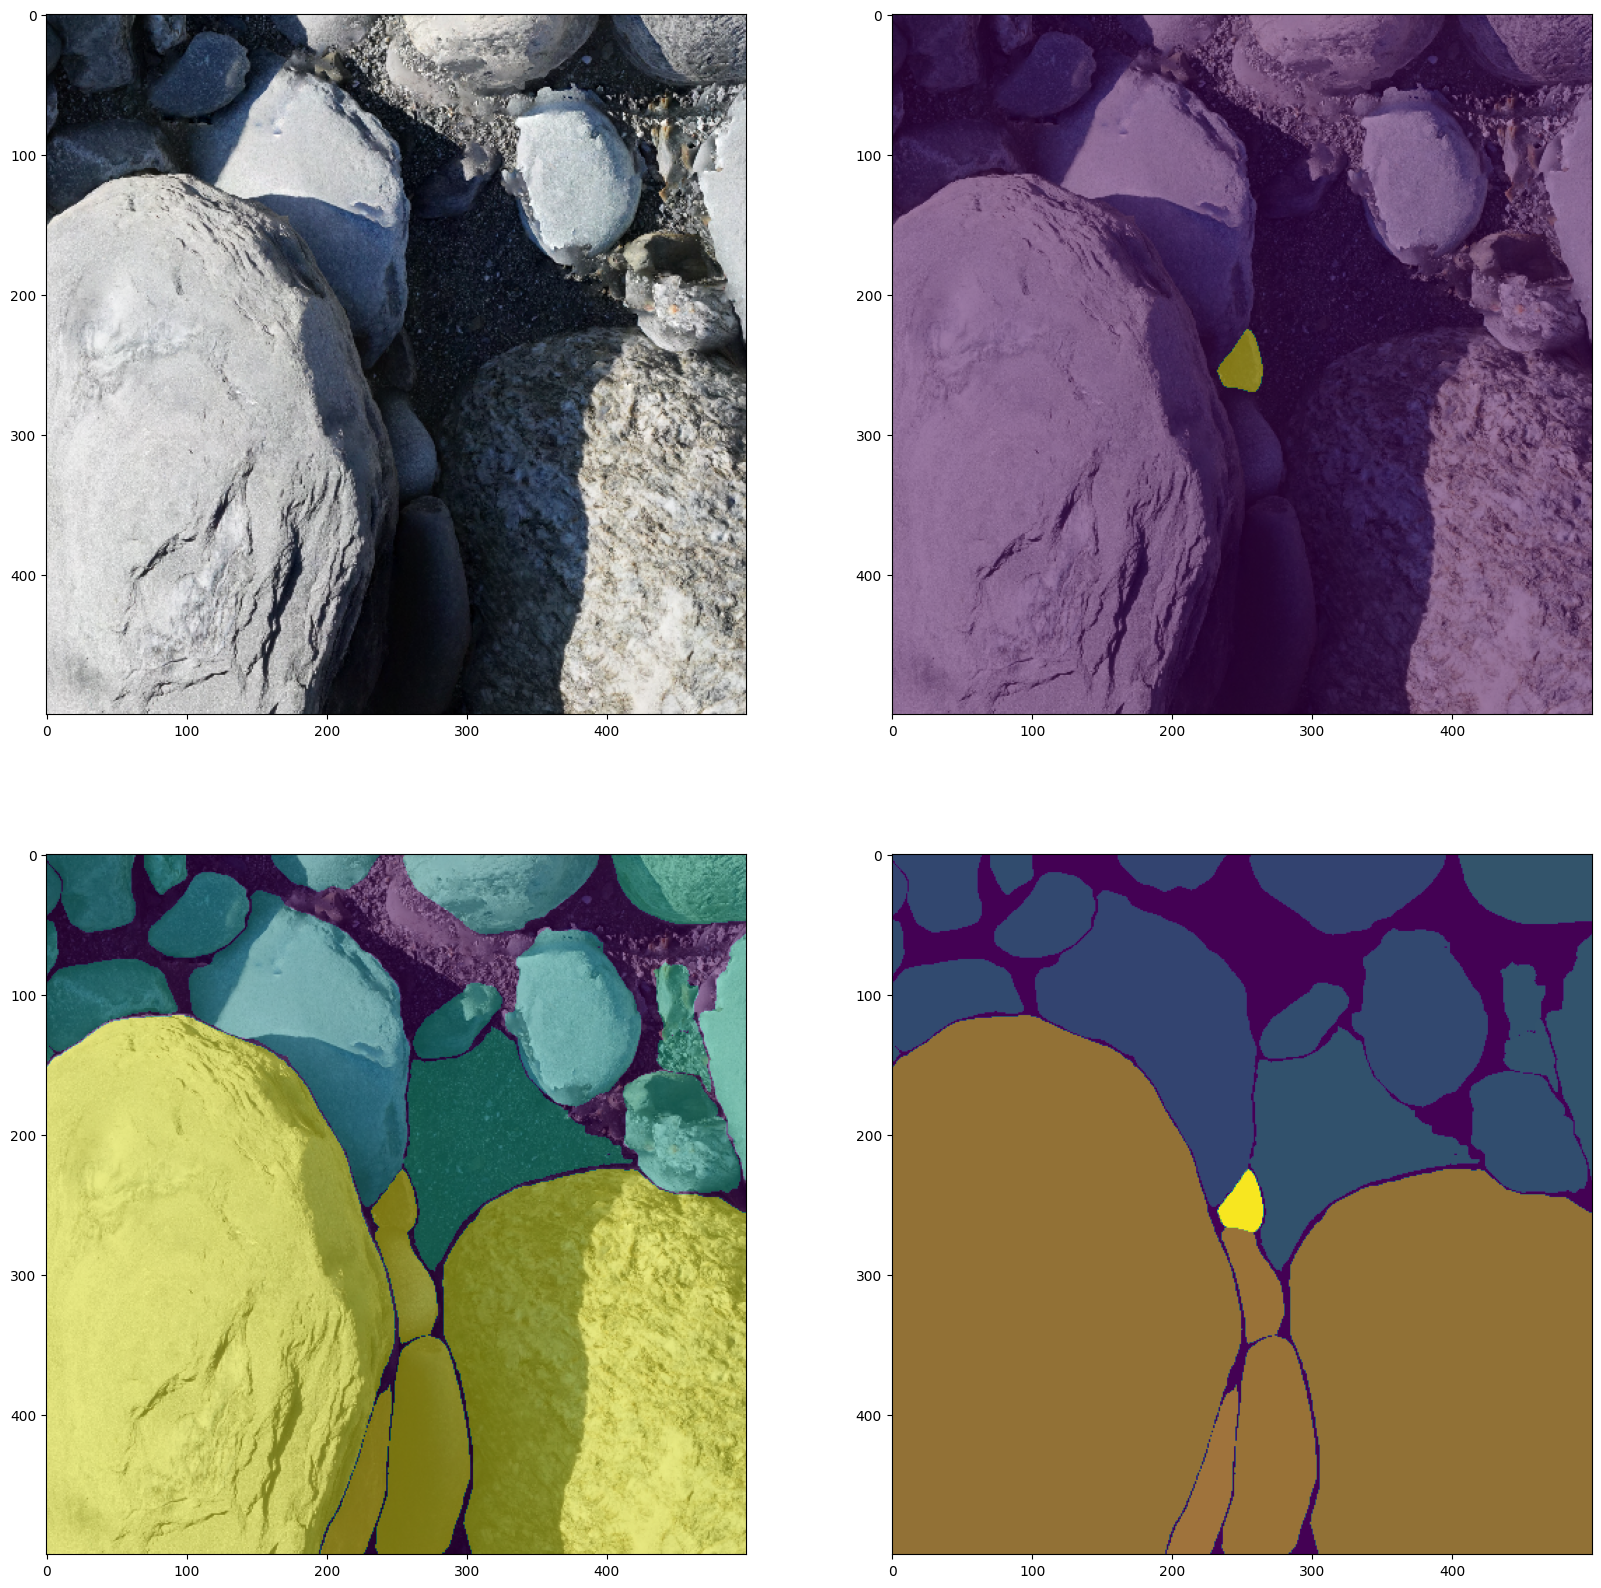

In [19]:
ws=500
id=10
nz=np.nonzero(problem_masks[id])
xmin,xmax=int(np.mean(nz[0])-ws/2),int(int(np.mean(nz[0])+ws/2))
ymin,ymax=int(np.mean(nz[1])-ws/2),int(np.mean(nz[1])+ws/2)
if xmin<0:
    xmin=0 
if ymin<0:
    ymin=0
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(image[xmin:xmax,ymin:ymax])
plt.subplot(2,2,2)
plt.imshow(image[xmin:xmax,ymin:ymax])
plt.imshow(problem_masks[id][xmin:xmax,ymin:ymax],alpha=0.5)
plt.subplot(2,2,3)
plt.imshow(image[xmin:xmax,ymin:ymax])
plt.imshow(id_mask[xmin:xmax,ymin:ymax],alpha=0.5)
plt.subplot(2,2,4)
plt.imshow(problem_masks[id][xmin:xmax,ymin:ymax])
plt.imshow(id_mask[xmin:xmax,ymin:ymax],alpha=0.5)

In [6]:
id_mask = np.zeros_like(image[:,:,0], dtype=np.uint32)
overlaping_ids,count=np.unique(id_mask[resized!=0], return_counts=True)

In [8]:
len(overlaping_ids)

1